<a href="https://colab.research.google.com/github/aniketmodi-work/AI-NMIMS/blob/master/CS50/Search/Degrees/Degrees_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Project by Aniket Modi, J064

## Degrees of Separation

### Background

According to the Six Degrees of Kevin Bacon game, anyone in the Hollywood film industry can be connected to Kevin Bacon within six steps, where each step consists of finding a film that two actors both starred in.

In this problem, we’re interested in finding the shortest path between any two actors by choosing a sequence of movies that connects them. For example, the shortest path between Jennifer Lawrence and Tom Hanks is 2: Jennifer Lawrence is connected to Kevin Bacon by both starring in “X-Men: First Class,” and Kevin Bacon is connected to Tom Hanks by both starring in “Apollo 13.”

We can frame this as a search problem: our states are people. Our actions are movies, which take us from one actor to another (it’s true that a movie could take us to multiple different actors, but that’s okay for this problem). Our initial state and goal state are defined by the two people we’re trying to connect. By using breadth-first search, we can find the shortest path from one actor to another.

### Understanding

The distribution code contains two sets of CSV data files: one set in the large directory and one set in the small directory. Each contains files with the same names, and the same structure, but small is a much smaller dataset for ease of testing and experimentation.

Each dataset consists of three CSV files. A CSV file, if unfamiliar, is just a way of organizing data in a text-based format: each row corresponds to one data entry, with commas in the row separating the values for that entry.

Open up small/people.csv. You’ll see that each person has a unique id, corresponding with their id in IMDb’s database. They also have a name, and a birth year.

Next, open up small/movies.csv. You’ll see here that each movie also has a unique id, in addition to a title and the year in which the movie was released.

Now, open up small/stars.csv. This file establishes a relationship between the people in people.csv and the movies in movies.csv. Each row is a pair of a person_id value and movie_id value. The first row (ignoring the header), for example, states that the person with id 102 starred in the movie with id 104257. Checking that against people.csv and movies.csv, you’ll find that this line is saying that Kevin Bacon starred in the movie “A Few Good Men.”

Next, take a look at degrees.py. At the top, several data structures are defined to store information from the CSV files. The names dictionary is a way to look up a person by their name: it maps names to a set of corresponding ids (because it’s possible that multiple actors have the same name). The people dictionary maps each person’s id to another dictionary with values for the person’s name, birth year, and the set of all the movies they have starred in. And the movies dictionary maps each movie’s id to another dictionary with values for that movie’s title, release year, and the set of all the movie’s stars. The load_data function loads data from the CSV files into these data structures.

The main function in this program first loads data into memory (the directory from which the data is loaded can be specified by a command-line argument). Then, the function prompts the user to type in two names. The person_id_for_name function retrieves the id for any person (and handles prompting the user to clarify, in the event that multiple people have the same name). The function then calls the shortest_path function to compute the shortest path between the two people, and prints out the path.

The shortest_path function, however, is left unimplemented. That’s where you come in!

### Function creation

Utility functions used

In [2]:
import csv
import sys

In [1]:
class Node():
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action


class StackFrontier():
    def __init__(self):
        self.frontier = []

    def add(self, node):
        self.frontier.append(node)

    def contains_state(self, state):
        return any(node.state == state for node in self.frontier)

    def empty(self):
        return len(self.frontier) == 0

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[-1]
            self.frontier = self.frontier[:-1]
            return node


class QueueFrontier(StackFrontier):

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[0]
            self.frontier = self.frontier[1:]
            return node

In [3]:
# Maps names to a set of corresponding person_ids
names = {}

# Maps person_ids to a dictionary of: name, birth, movies (a set of movie_ids)
people = {}

# Maps movie_ids to a dictionary of: title, year, stars (a set of person_ids)
movies = {}

Function to load the data

In [4]:
def load_data(directory):
    """
    Load data from CSV files into memory.
    """
    # Load people
    with open(f"{directory}/people.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            people[row["id"]] = {
                "name": row["name"],
                "birth": row["birth"],
                "movies": set()
            }
            if row["name"].lower() not in names:
                names[row["name"].lower()] = {row["id"]}
            else:
                names[row["name"].lower()].add(row["id"])

    # Load movies
    with open(f"{directory}/movies.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            movies[row["id"]] = {
                "title": row["title"],
                "year": row["year"],
                "stars": set()
            }

    # Load stars
    with open(f"{directory}/stars.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                people[row["person_id"]]["movies"].add(row["movie_id"])
                movies[row["movie_id"]]["stars"].add(row["person_id"])
            except KeyError:
                pass

Functions to get person and their neighbours

In [17]:
def person_id_for_name(name):
    """
    Returns the IMDB id for a person's name,
    resolving ambiguities as needed.
    """
    person_ids = list(names.get(name.lower(), set()))
    if len(person_ids) == 0:
        return None
    elif len(person_ids) > 1:
        print(f"Which '{name}'?")
        for person_id in person_ids:
            person = people[person_id]
            name = person["name"]
            birth = person["birth"]
            print(f"ID: {person_id}, Name: {name}, Birth: {birth}")
        try:
            person_id = input("Intended Person ID: ")
            if person_id in person_ids:
                return person_id
        except ValueError:
            pass
        return None
    else:
        return person_ids[0]



def neighbors_for_person(person_id):
    """
    Returns (movie_id, person_id) pairs for people
    who starred with a given person.
    """
    movie_ids = people[person_id]["movies"]
    neighbors = set()
    for movie_id in movie_ids:
        for person_id in movies[movie_id]["stars"]:
            neighbors.add((movie_id, person_id))
    return neighbors

Implements stack and queue frontiers

In [13]:
def get_solution(node, target):
    # If node is the goal, then we have a solution
    if node.state == target:
        path = []
        while node.parent is not None:
            path.append((node.action, node.state))
            node = node.parent
        path.reverse()
        return path
    return None

**Function to get shortest path**

In [15]:
def shortest_path(source, target):
    """
    Returns the shortest list of (movie_id, person_id) pairs
    that connect the source to the target.
    If no possible path, returns None.
    """
    # TODO
    # Keep track of number of states explored
    num_explored = 0

    # Initialize frontier to just the starting position
    start = Node(state=source, parent=None, action=None)
    frontier = QueueFrontier()
    frontier.add(start)

    # Initialize an empty explored set
    explored = set()

    # Keep looping until solution found
    while True:

        # If nothing left in frontier, then no path
        if frontier.empty():
            return None

        # Choose a node from the frontier
        node = frontier.remove()
        num_explored += 1

        solution = get_solution(node, target)
        if solution:
            return solution

        # Mark node as explored
        explored.add(node.state)

        # Add neighbors to frontier
        for movie, state in neighbors_for_person(node.state):
            if not frontier.contains_state(state) and state not in explored:
                child = Node(state=state, parent=node, action=movie)
                solution = get_solution(child, target)
                if solution:
                    return solution
                frontier.add(child)

    return None

### Function deployment

In [ ]:
def degrees():  

    source = person_id_for_name(input("Name: "))

    if source is None:
        sys.exit("Person not found.")
    target = person_id_for_name(input("Name: "))
    if target is None:
        sys.exit("Person not found.")

    path = shortest_path(source, target)

    if path is None:
        print("Not connected.")
    else:
        degrees = len(path)
        print(f"{degrees} degrees of separation.")
        path = [(None, source)] + path
        for i in range(degrees):
            person1 = people[path[i][1]]["name"]
            person2 = people[path[i + 1][1]]["name"]
            movie = movies[path[i + 1][0]]["title"]
            print(f"{i + 1}: {person1} and {person2} starred in {movie}")

#### For Small dataset

Loading data from Google Drive

In [5]:
print("Loading data...")
load_data('/content/drive/My Drive/DATASETS/degrees/small')
print("Data loaded.")

Loading data...
Data loaded.


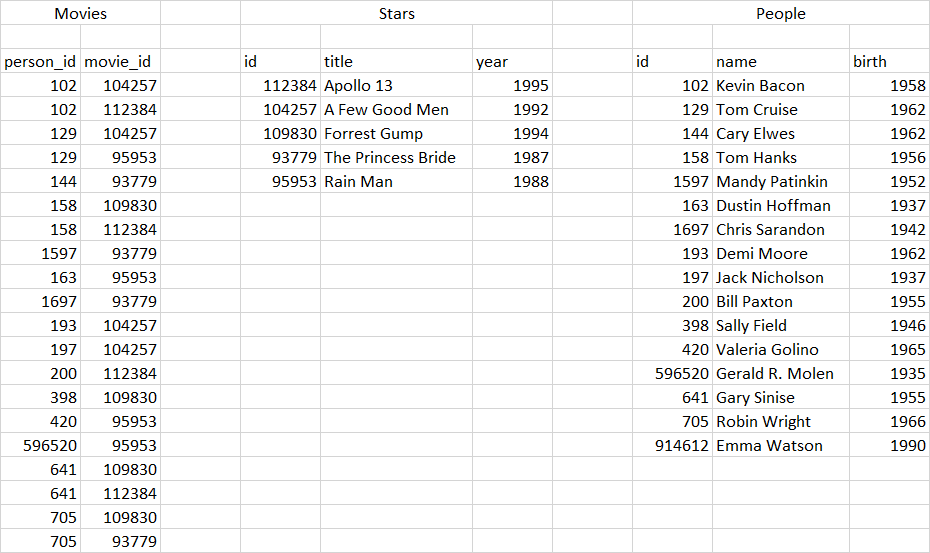

Checking for Tom Hanks and Tom Cruise

In [21]:
degrees()

Name: Tom Cruise
Name: Tom Hanks
2 degrees of separation.
1: Tom Cruise and Kevin Bacon starred in A Few Good Men
2: Kevin Bacon and Tom Hanks starred in Apollo 13


Checking for Kevin Bacon and Emma Watson

In [22]:
degrees()

Name: Kevin Bacon
Name: Emma Watson
Not connected.


### For Large Dataset

In [23]:
print("Loading data...")
load_data('/content/drive/My Drive/DATASETS/degrees/large')
print("Data loaded.")

Loading data...
Data loaded.


Checking for Shah Rukh Khan and Amitabh Bachchan

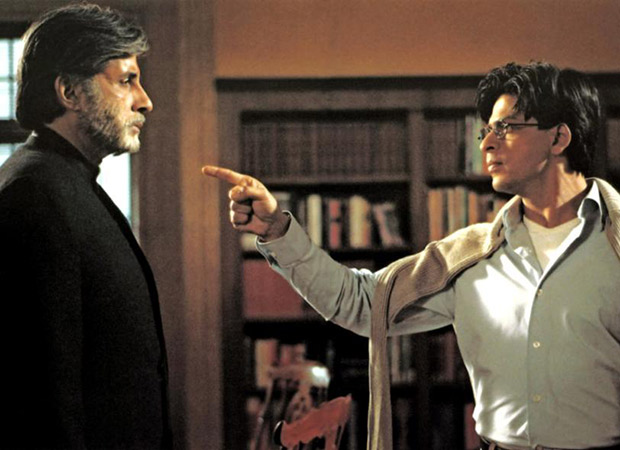

In [24]:
degrees()

Name: Shah Rukh Khan
Name: Amitabh Bachchan
1 degrees of separation.
1: Shah Rukh Khan and Amitabh Bachchan starred in Kabhi Alvida Naa Kehna


Checking for Marlon Brando a.k.a Vito Corleone (Original Godfather) and Al Pacino a.k.a Michael Corleone (New Godfather)

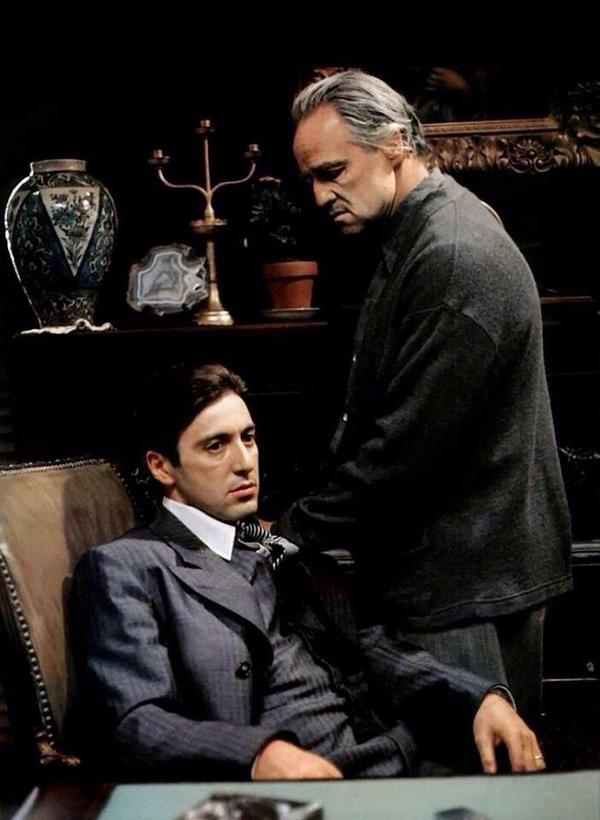

In [25]:
degrees()

Name: Marlon Brando
Name: Al Pacino
1 degrees of separation.
1: Marlon Brando and Al Pacino starred in The Godfather
